In [78]:
# win32 com
#http://www.s-anand.net/blog/automating-powerpoint-with-python/
#https://docs.microsoft.com/en-us/office/vba/api/powerpoint.fillformat.visible
import win32com.client
import os
import random
import numpy as np
import PIL
import tensorflow as tf
from tqdm import tqdm

In [79]:
Application = win32com.client.Dispatch('PowerPoint.Application')
slide_height, slide_width = 540, 720
MAX_SEQ_LEN = 6 # includesstart and end token
IMAGE_RES_DIVISOR = 2

In [216]:
# Presentation = Application.Presentations.Open(os.getcwd()+ '\\Presentation.pptx') # need full path with win22com
# Create a new ppt deck
Presentation = Application.Presentations.Add()

In [217]:
#https://docs.microsoft.com/en-us/office/vba/api/office.msoautoshapetype
shapes = { 'Rectangle': 1,
       'Chevron': 52,
         'Oval': 9}

custom_tokens = {
    'start': 0,
    'stop': 1,
    'pad': 2,
}
num_shapes = len(shapes)
num_classes = len(custom_tokens)+num_shapes

In [218]:
def RGB(rgb):
    return rgb[2]*256**2 + rgb[1]*256 + rgb[0]

def add_shape(slide, ID, x,y,h,w, rgb, border=0, fill = 1, text=0):
    '''
    rgb must be 0-1 ranges
    text just signifies if it has text, that one is a bit of a text to see how good the textures we can
    pick up are
    pages are 720 x 540 - IMO lets enter objects as % width (so that they are 0-1 range)
    
    '''
    # this is writing the properties
    x,w, y,h = x*slide_width, w*slide_width, y*slide_height, h*slide_height
    shape = slide.Shapes.AddShape(ID, x,y,w,h)
    # to read them, 
    shape.Fill.Solid() # gradient being the default must be a callback from some weird past
    shape.Fill.ForeColor.RGB  = RGB(np.array(rgb)*255)
    shape.Fill.Visible = fill
    shape.Line.Visible = border
    
    if text > 0: # eventually we'll be able to make a rule for whether white or black text is better 
        # based on fill rgb
        shape.TextFrame.TextRange.Text = 'xx'
        shape.TextFrame.TextRange.Font.Color.RGB  = RGB([0,0,0])
        shape.TextFrame.TextRange.Font.Size = 18

    return shape

In [219]:
def long_to_rgb(C):
    R = C % 256
    G = C // 256 % 256
    B = C // 65536 % 256
    
    return np.array([R,G,B])/255
    
    
def read_shape(shape):
    #https://docs.microsoft.com/en-us/office/vba/api/powerpoint.shape
    x=shape.Left/slide_width
    y=shape.Top/slide_height
    height = shape.Height/slide_height
    width = shape.Width/slide_width
    name = "".join(shape.Name.split(' ')[:-1]) # cames as type (split by spaces, with a number at the end)
    fillRGB =long_to_rgb(shape.Fill.ForeColor.RGB)
    fill = abs(shape.Fill.Visible) # sometimes returns -1 if not set, but its still visible in that case
    border = abs(shape.Line.Visible)
    if shape.TextFrame.TextRange.Text != '':
        text = 1
    else: # just detect the presence of text atm, to make it easier to fill in.
        text = 0
    return name, x,y,height,width, fillRGB, border, fill, text

#ID, x,y,h,w, rgb, border, fill,text = read_shape(shape)
# ID, x,y,h,w, rgb, border, fill,text

In [220]:
# Alright, lets generate some training data!
def make_training_data_slide():
    slide = Presentation.Slides.Add(1, 12)
    num_shapes = np.random.randint(1,MAX_SEQ_LEN-2) # MAX_SEQ_LEN includes start and end token
    created_shapes = []
    
    segments = [{'x1':0.1, 'x2':0.2, 'y1':0.1, 'y2':0.4}, {'x1':0.3, 'x2':0.5, 'y1':0.1, 'y2':0.4}, {'x1':0.7, 'x2':0.9, 'y1':0.1, 'y2':0.4}, 
               {'x1':0.1, 'x2':0.2, 'y1':0.5, 'y2':0.9}, {'x1':0.3, 'x2':0.5, 'y1':0.5, 'y2':0.9} , {'x1':0.7, 'x2':0.9, 'y1':0.5, 'y2':0.9}]
    
    for s in range(0,num_shapes):
        shapeID = np.random.choice(list(shapes.keys()))
        segment = segments[s]
        x = np.random.uniform(segment['x1'],segment['x2'])
        y = np.random.uniform(segment['y1'],segment['y2'])
        h = min(np.random.uniform(0.1,0.4), 1-y)
        w = min(np.random.uniform(0.1,0.4), 1-x) # don't want it bigger than the frame
        
        rgb = np.zeros(3) # default 0
        border = 0 #default 0 
        fill = 1# np.random.randint(2)
        if fill == 1:
            col = np.random.randint(3)
            rgb[col] = 1 # literally only do r, g or b at the moment. This isn't a color accuracy test
        else:
            border = 1 # if not filled, then do a border
        text = 0# np.random.randint(2)
        shape  = add_shape(slide, shapes[shapeID], x,y,h,w, rgb, border, fill,text)
    return slide

        
def generic_token():
    return {
        'ID': 0,
        'pos': np.zeros(2),
        'dimensions': np.zeros(2),
        'color': np.zeros(3),
        'border': 0,
        'fill': 0,
        'text':0, }

# shape info to vector
def shape2vec(shape):
    ID, x,y,h,w, rgb, border, fill,text = read_shape(shape)
    shape_id = len(custom_tokens)+list(shapes.keys()).index(ID) 

    return {
        'ID': shape_id,
        'pos': np.array([x,y]),
        'dimensions': np.array([x,y]),
        'color': np.array(rgb),
        'border': border,
        'fill': fill,
        'text':text}

def generate_start_token():
    t = generic_token()
    t['ID'] = 1
    return t


def generate_end_token():
    t = generic_token()
    t['ID'] = 2
    return t

def generate_pad_token():
    t = generic_token()
    t['ID'] = 0
    return t


# Make the deck of examples

In [221]:
train_path =  os.getcwd()+ '\\data\\train'
test_path =  os.getcwd()+ '\\data\\test'
path = test_path

In [222]:
for i in tqdm(range(0,1000)):
    make_training_data_slide()    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:41<00:00,  6.19it/s]


# Save images to disk

In [228]:
dataset = {k: [] for k in list(generic_token().keys())+['img_paths','seq_lens','seq_masks']}


for i,slide in tqdm(enumerate(Presentation.Slides)):
    example = {k:[] for k in generic_token().keys()}
    
    tokens = [generate_start_token()] + [shape2vec(shape) for shape in slide.shapes] + [generate_end_token()] 
    padding = [generate_pad_token()]*(MAX_SEQ_LEN-len(tokens))
    sequence = tokens+padding
    for k in example.keys():
        for t in sequence:
            example[k].append(t[k])
        example[k] = np.array(example[k])
        # now the example is complete, add it to the dataset for that dimension
        dataset[k].append(example[k])


    img_path = path+'\\images\\'+ f'{i}.jpg'
    dataset['img_paths'].append(img_path)
    dataset['seq_lens'].append(len(tokens))
    dataset['seq_masks'].append(np.concatenate([ np.ones(len(tokens)), np.zeros(len(padding))]))
    slide.Export(img_path, 'JPG', 256, 256)

for k in generic_token().keys():
    dataset[k] = np.array(dataset[k])
    
dataset['seq_masks'] = np.array(dataset['seq_masks']).astype(np.float32) 

1000it [01:08, 14.53it/s]


In [229]:
np.savez(path + '/metadata', dataset=dataset, img_tokens=IMG_TOKENS, 
         language_tokens=0, vec_dim=VEC_DIM, component_tokens= MAX_SEQ_LEN, allow_pickle=True)

# Put these into TF records

In [230]:
dataset = np.load(path + '/metadata.npz', allow_pickle = True)['dataset'].item()

In [231]:
from importlib import reload
from natsort import natsorted
reload(lib.data)
import lib
from lib.data import transform_dataset, serialise, dataloader

In [232]:
# first things first, make a TF dataset from the vecs and paths
full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
# then, load the images with tf.io and serialise
full_dataset = transform_dataset(full_dataset)
it = iter(full_dataset)

# Write the records to a file.
record_idx = 0
with tf.io.TFRecordWriter(f"{path}\\tf_records\\{record_idx}.tfrecords") as file_writer:
    for i, data in enumerate(it):
        byte_stream = serialise(data)
        file_writer.write(byte_stream)
        if i % 1000 == 0: record_idx += 1

# Test the TFR

In [206]:

dl = dataloader(path)

In [207]:
ds = iter(dl.dataset)

In [208]:
d= ds.next()

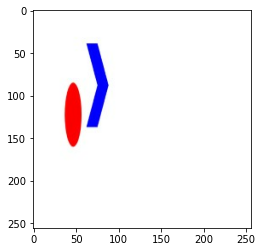

In [209]:
import matplotlib.pyplot as plt
plt.imshow(d['img'][5])

In [211]:
d['sequence'][5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 5, 4, 2, 0])>

In [212]:
d['seq_mask'][5]

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 1., 1., 1., 0., 0.], dtype=float32)>

In [378]:
from lib.dall_e_jax import get_encoder

ModuleNotFoundError: No module named 'jax'

In [224]:
shape.delete()
shape  = add_shape(slide, shapes[ID], x,y,h,w, rgb, border, fill,text)

In [232]:
list(shapes.keys())

['Rectangle', 'RectangularCallout', 'Chevron', 'Oval']

In [61]:
Presentation.save()

com_error: (-2147352567, 'Exception occurred.', (0, 'Microsoft PowerPoint', 'Presentation.Save : Object does not exist.', '', 0, -2147188720), None)

In [27]:
for i in range(0,2000):
    make_training_data_slide()    
    


In [48]:
dataset = []
for i,slide in enumerate(Presentation.Slides):
    vecs = []
    vecs.append(np.squeeze(generate_start_token(1)))
    for shape in slide.Shapes:
        vecs.append(shape2vec(shape))
    vecs.append(np.squeeze(generate_end_token(1)))
        
    dataset.append(np.array(vecs))
    #slide.Export(os.getcwd()+ '\\training_data\\images\\'+ f'{i}.png', 'PNG', slide_width//2, slide_height//2)
    
np.savez("training_data/vectors", dataset=dataset)
        
    

In [42]:
generate_start_token(1).shape

(1, 16)

In [43]:
shape2vec(shape).shape

(15,)

In [55]:
np.load("training_data/vectors.npz", allow_pickle=True)['dataset'][0].shape
        

(6, 15)

In [60]:
for i in range(0,2010):
    print(dataset[i].shape)

(6, 15)
(4, 15)
(3, 15)
(5, 15)
(4, 15)
(5, 15)
(6, 15)
(5, 15)
(6, 15)
(4, 15)
(5, 15)
(6, 15)
(5, 15)
(6, 15)
(3, 15)
(5, 15)
(6, 15)
(6, 15)
(5, 15)
(4, 15)
(5, 15)
(4, 15)
(3, 15)
(4, 15)
(6, 15)
(6, 15)
(6, 15)
(5, 15)
(6, 15)
(5, 15)
(5, 15)
(3, 15)
(4, 15)
(6, 15)
(4, 15)
(4, 15)
(6, 15)
(4, 15)
(4, 15)
(5, 15)
(5, 15)
(6, 15)
(3, 15)
(3, 15)
(3, 15)
(4, 15)
(3, 15)
(6, 15)
(6, 15)
(3, 15)
(6, 15)
(3, 15)
(3, 15)
(4, 15)
(5, 15)
(5, 15)
(4, 15)
(4, 15)
(3, 15)
(5, 15)
(5, 15)
(3, 15)
(4, 15)
(5, 15)
(3, 15)
(3, 15)
(3, 15)
(4, 15)
(6, 15)
(5, 15)
(6, 15)
(3, 15)
(5, 15)
(5, 15)
(6, 15)
(4, 15)
(5, 15)
(6, 15)
(4, 15)
(5, 15)
(6, 15)
(4, 15)
(5, 15)
(4, 15)
(3, 15)
(4, 15)
(6, 15)
(3, 15)
(6, 15)
(4, 15)
(5, 15)
(4, 15)
(3, 15)
(3, 15)
(6, 15)
(3, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(4, 15)
(4, 15)
(6, 15)
(4, 15)
(4, 15)
(3, 15)
(5, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(4, 15)
(5, 15)
(5, 15)
(5, 15)
(5, 15)
(4, 15)
(5, 15)
(3, 15)
(6, 15)
(3, 15)
(3, 15)
(3, 15)
(6, 15)
(6, 15)


(3, 15)
(5, 15)
(3, 15)
(6, 15)
(5, 15)
(3, 15)
(4, 15)
(4, 15)
(3, 15)
(3, 15)
(4, 15)
(5, 15)
(6, 15)
(3, 15)
(5, 15)
(3, 15)
(3, 15)
(6, 15)
(6, 15)
(4, 15)
(5, 15)
(3, 15)
(4, 15)
(4, 15)
(5, 15)
(3, 15)
(3, 15)
(4, 15)
(6, 15)
(3, 15)
(6, 15)
(4, 15)
(3, 15)
(4, 15)
(6, 15)
(6, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(4, 15)
(4, 15)
(6, 15)
(4, 15)
(3, 15)
(3, 15)
(4, 15)
(4, 15)
(3, 15)
(4, 15)
(4, 15)
(3, 15)
(3, 15)
(6, 15)
(5, 15)
(3, 15)
(6, 15)
(4, 15)
(4, 15)
(6, 15)
(5, 15)
(6, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(4, 15)
(6, 15)
(4, 15)
(5, 15)
(6, 15)
(4, 15)
(6, 15)
(4, 15)
(5, 15)
(5, 15)
(4, 15)
(4, 15)
(6, 15)
(6, 15)
(6, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(3, 15)
(5, 15)
(6, 15)
(6, 15)
(6, 15)
(4, 15)
(5, 15)
(5, 15)
(6, 15)
(5, 15)
(3, 15)
(5, 15)
(4, 15)
(3, 15)
(4, 15)
(3, 15)
(5, 15)
(6, 15)
(5, 15)
(6, 15)
(5, 15)
(3, 15)
(4, 15)
(6, 15)
(3, 15)
(3, 15)
(6, 15)
(5, 15)
(5, 15)
(6, 15)
(3, 15)
(5, 15)
(5, 15)
(3, 15)
(5, 15)
(6, 15)


IndexError: list index out of range

In [86]:
# dataset = {k: [] for k in generic_token().keys()+['img_paths','seq_lens','seq_masks']}

# IMG_TOKENS = 1024
# for i,slide in tqdm(enumerate(Presentation.Slides)):
#     vecs = []
#     vecs.append(np.squeeze(generate_start_token(1)))
#     for shape in slide.Shapes:
#         vecs.append(shape2vec(shape))
#     vecs.append(np.squeeze(generate_end_token(1)))
#     # pad out the remainder
#     vecs = np.array(vecs) # T, D
#     seq_len = vecs.shape[0]
#     pad_len = MAX_SEQ_LEN - seq_len
#     vecs = np.concatenate([vecs, np.zeros([pad_len, VEC_DIM])]).astype(np.float32)
#     img_path = path+'\\images\\'+ f'{i}.jpg'
#     dataset['vecs'].append(vecs)
#     dataset['img_paths'].append(img_path)
#     dataset['seq_lens'].append(seq_len)
#     # subtract one from seq len and add one to pad len because
#     # we want 0 mask on the 'end' tokens spot, as it we don't predict on it
#     dataset['seq_masks'].append( np.concatenate([ np.ones([IMG_TOKENS]), np.ones([seq_len-1]), np.zeros([pad_len+1])]).astype(np.int32))
    
    
#     #slide.Export(img_path, 'JPG', 256, 256)#slide_width//IMAGE_RES_DIVISOR, slide_height//IMAGE_RES_DIVISOR)

0it [00:00, ?it/s]


NameError: name 'VEC_DIM' is not defined

In [212]:
Presentation.Slides[0]

<COMObject <unknown>>

In [149]:
shape.Line.Visible = 1
shape.Fill.Visible = 0

In [208]:
shape.delete()
shape  = add_shape(slide, shapes['RectangularCallout'], 0.5,0.5,0.3,0.4, [0.003,0,1], text=0)

In [315]:
#slide.Export(os.getcwd()+ '\\training_data\\images\\'+ f'{i}.png', 'PNG', slide_width, slide_height)

In [198]:
shape.TextFrame.TextRange.Text 
# We access 

''

In [107]:
from pptx.enum.shapes import MSO_SHAPE
MSO_SHAPE.CLOUD_CALLOUT

108

In [106]:
dir(MSO_SHAPE)

['ACTION_BUTTON_BACK_OR_PREVIOUS',
 'ACTION_BUTTON_BEGINNING',
 'ACTION_BUTTON_CUSTOM',
 'ACTION_BUTTON_DOCUMENT',
 'ACTION_BUTTON_END',
 'ACTION_BUTTON_FORWARD_OR_NEXT',
 'ACTION_BUTTON_HELP',
 'ACTION_BUTTON_HOME',
 'ACTION_BUTTON_INFORMATION',
 'ACTION_BUTTON_MOVIE',
 'ACTION_BUTTON_RETURN',
 'ACTION_BUTTON_SOUND',
 'ARC',
 'BALLOON',
 'BENT_ARROW',
 'BENT_UP_ARROW',
 'BEVEL',
 'BLOCK_ARC',
 'CAN',
 'CHART_PLUS',
 'CHART_STAR',
 'CHART_X',
 'CHEVRON',
 'CHORD',
 'CIRCULAR_ARROW',
 'CLOUD',
 'CLOUD_CALLOUT',
 'CORNER',
 'CORNER_TABS',
 'CROSS',
 'CUBE',
 'CURVED_DOWN_ARROW',
 'CURVED_DOWN_RIBBON',
 'CURVED_LEFT_ARROW',
 'CURVED_RIGHT_ARROW',
 'CURVED_UP_ARROW',
 'CURVED_UP_RIBBON',
 'DECAGON',
 'DIAGONAL_STRIPE',
 'DIAMOND',
 'DODECAGON',
 'DONUT',
 'DOUBLE_BRACE',
 'DOUBLE_BRACKET',
 'DOUBLE_WAVE',
 'DOWN_ARROW',
 'DOWN_ARROW_CALLOUT',
 'DOWN_RIBBON',
 'EXPLOSION1',
 'EXPLOSION2',
 'FLOWCHART_ALTERNATE_PROCESS',
 'FLOWCHART_CARD',
 'FLOWCHART_COLLATE',
 'FLOWCHART_CONNECTOR',
 'FLOW

In [82]:
shape.Fill.Visible = 0

In [89]:
shape.TextFrame.TextRange.Text = 'Hey'
shape.TextFrame.TextRange.Font.Color.RGB


'Hey'

18.0

In [75]:
for j in slide.Shapes:
    j.delete()

In [22]:
slide.Shapes.AddShape(1, 100, 100, 200, 200)

<COMObject AddShape>

In [42]:
vars(shape)

{'_oleobj_': <PyIDispatch at 0x0000016A9A366010 with obj at 0x0000016A9E8193B8>,
 '_username_': 'AddShape',
 '_olerepr_': <win32com.client.build.LazyDispatchItem at 0x16aa0903c08>,
 '_mapCachedItems_': {},
 '_builtMethods_': {},
 '_enum_': None,
 '_unicode_to_string_': None,
 '_lazydata_': (<PyITypeInfo at 0x0000016A9A366070 with obj at 0x0000016A9E819508>,
  <PyITypeComp at 0x0000016A9A365DA0 with obj at 0x0000016A9E818D98>)}